In [1]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.risk as risk
import mlgrad.avragg as avragg
# import mlgrad.gd as gd
import mlgrad.func2 as func2
import mlgrad.weights as weights
from mlgrad.utils import exclude_outliers

import mlgrad.regr as regr

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt

import sys
print(sys.version)

3.11.1 (main, Dec 31 2022, 10:23:59) [GCC 12.2.0]


In [2]:
df = pd.read_csv("data/gesell.csv", sep=',')

In [3]:
len(df)

21

In [4]:
df

,age,score
0,15,95
1,26,71
2,10,83
3,9,91
4,15,102
5,20,87
6,18,93
7,11,100
8,8,104
9,20,94


In [5]:
X = df["age"].values
Y = df["score"].values

X = np.asarray(X, 'd')
Y = np.asarray(Y, 'd')

c_x = np.median(X)
c_y = np.median(Y)
s_x = np.median(np.abs(X - c_x)) 
s_y = np.median(np.abs(Y - c_y))

X = (X - c_x) / s_x
Y = (Y - c_y) / s_y

# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

X0 = np.linspace(X.min(), X.max(), 20)

N = len(Y)

In [6]:
from sklearn.preprocessing import scale

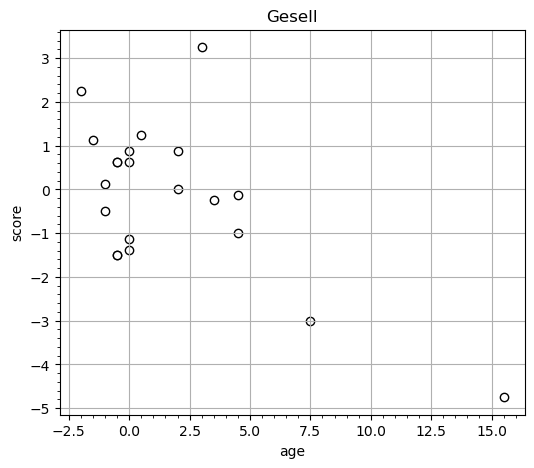

In [7]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidths=1.)
plt.title('Gesell')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('age')
plt.ylabel('score')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.show()

In [8]:
loss_func_sq = loss.ErrorLoss(func.Square())
# loss_func_rsq = loss.RelativeErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [9]:
sqr_norm = func2.SquareNorm()

In [10]:
alpha = (N-5)/N
alpha = int(alpha * 100)/100
print(alpha)

0.76


In [11]:
mod_ls = model.LinearModel(1)
mod_ls.init_param()

K=930 param=[ 0.30257466 -0.2805286 ]


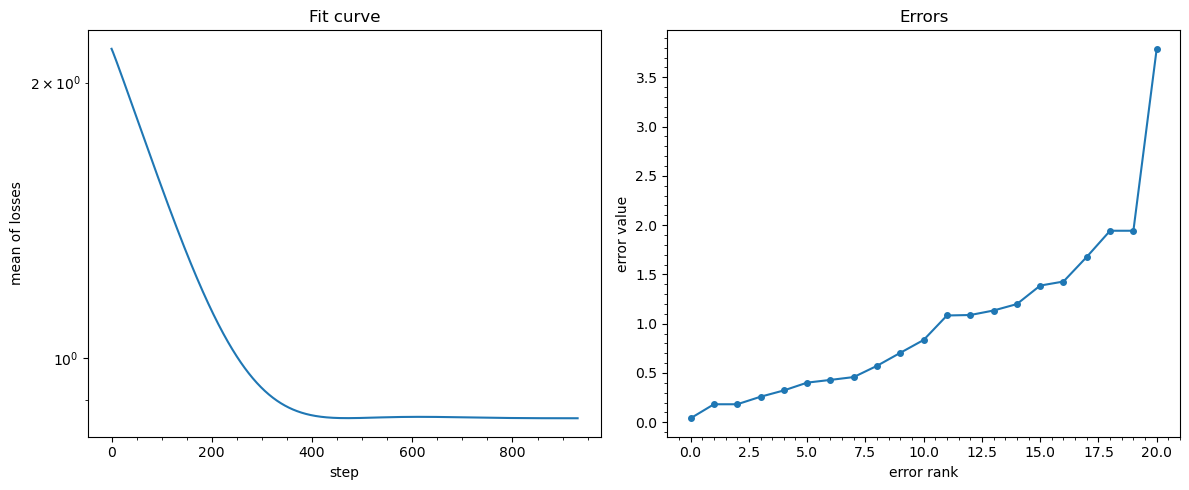

In [12]:
alg_ls = regr.regression(Xs, Y, mod_ls, n_iter=2000, verbose=1)
err_ls = regr.plot_losses_and_errors(alg_ls, Xs, Y)

In [13]:
mod_m_irls = model.LinearModel(1)
mod_m_irls.init_param()

0.7955976325178168
K=99 param=[ 0.42633904 -0.33396807]


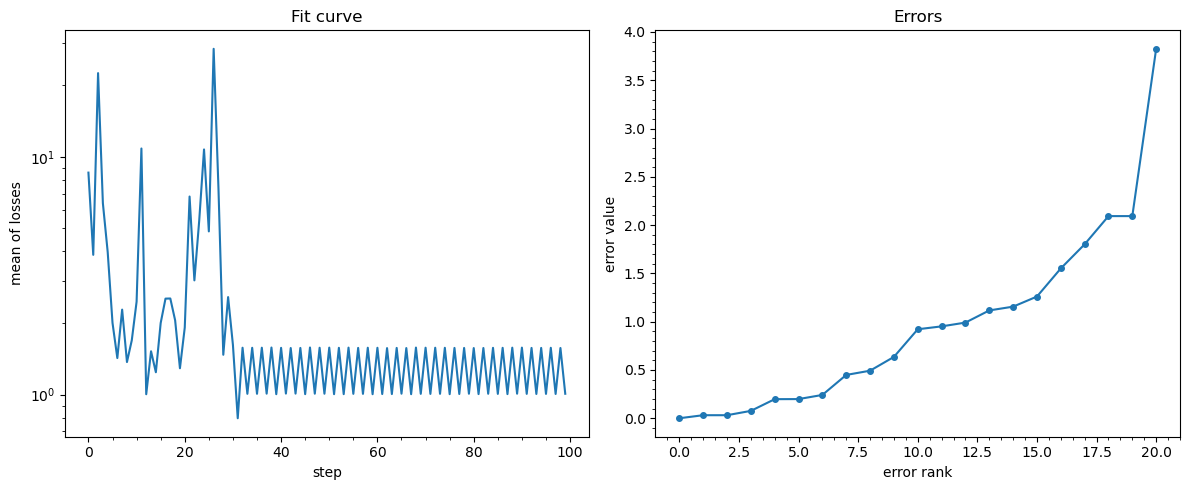

In [14]:
avg_m_irls = regr.averaging_function('M', rhofunc=func.Quantile_Sqrt(alpha, 0.001))
alg_m_irls = regr.m_regression_irls(Xs, Y, mod_m_irls, agg_func=avg_m_irls, 
                                    h=0.01, n_iter=400, n_iter2=100, verbose=1)
err_m_irls = regr.plot_losses_and_errors(alg_m_irls, Xs, Y)

In [15]:
mod_wm_irls = model.LinearModel(1)
mod_wm_irls.init_param()

0.3876951892369348
K=99 param=[ 0.49079161 -0.32714797]


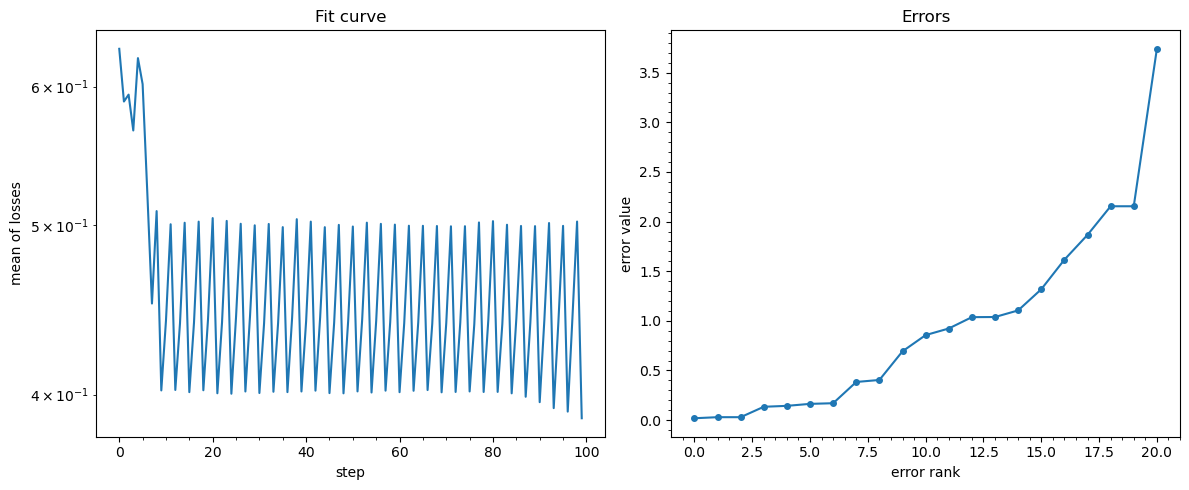

In [16]:
avg_wm_irls = regr.averaging_function('WM', rhofunc=func.QuantileFunc(alpha, func.Sqrt(0.001)))
alg_wm_irls = regr.m_regression_irls(Xs, Y, mod_wm_irls, 
                                     agg_func=avg_wm_irls, 
                                     h=0.01, n_iter=100, n_iter2=100, verbose=1)
err_wm_irls = regr.plot_losses_and_errors(alg_wm_irls, Xs, Y)

In [17]:
mod_swm_irls = model.LinearModel(1)
mod_swm_irls.init_param()

0.5705131740460498
K=99 param=[ 0.36252246 -0.34081527]


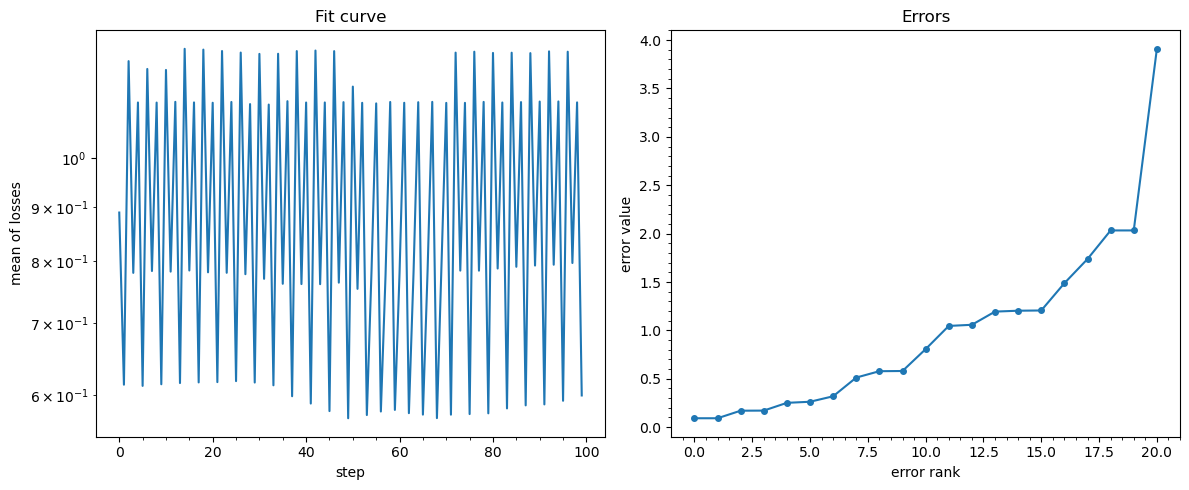

In [18]:
avg_swm_irls = regr.averaging_function('SWM', rhofunc=func.QuantileFunc(alpha, func.Sqrt(0.001)))
alg_swm_irls = regr.m_regression_irls(Xs, Y, mod_swm_irls, 
                                      agg_func=avg_swm_irls, 
                                      h=0.01, n_iter=400, n_iter2=100, verbose=1)
err_swm_irls = regr.plot_losses_and_errors(alg_swm_irls, Xs, Y)

In [19]:
# Err = np.abs(Y - mod2.evaluate_all(Xs))

# X1, X1_ = array_exclude_outliers(X, Err, 7) 
# Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
# X1s = X1.reshape(-1,1)

In [20]:
mod_r_irls = model.LinearModel(1)
mod_r_irls.init_param()

0.5148950573748242
K=4 param=[ 0.30195499 -0.30265321]


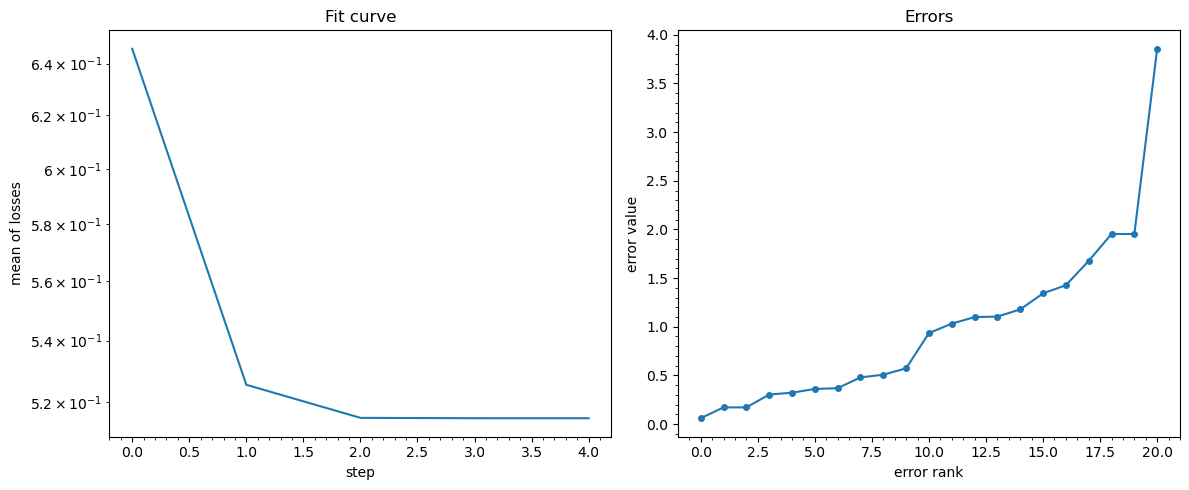

In [21]:
alg_r_irls = regr.r_regression_irls(Xs, Y, mod_r_irls, rho_func=func.Huber(), verbose=1)
err_r_irls = regr.plot_losses_and_errors(alg_r_irls, Xs, Y)

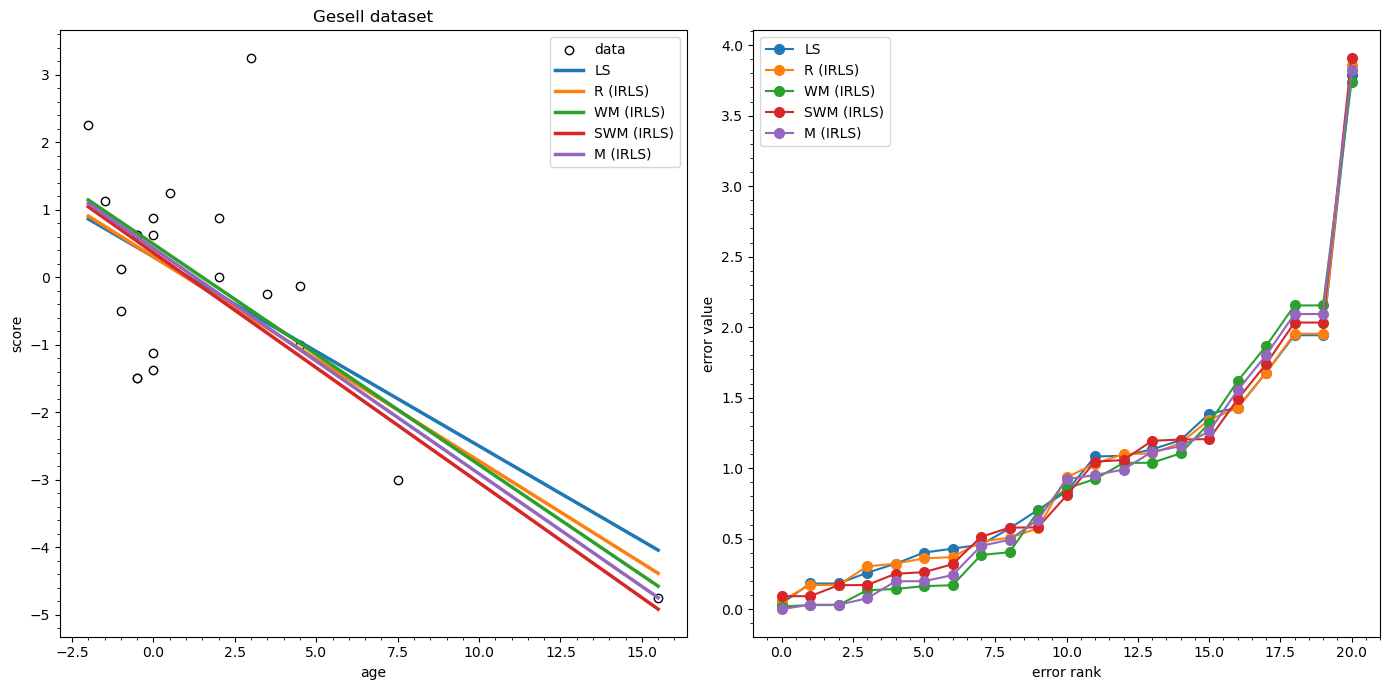

In [22]:
plt.figure(figsize=(14.0, 7.0))
plt.subplot(1,2,1)
plt.title('Gesell dataset')
plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidths=1., label='data')
plt.plot(X0, mod_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'LS')
plt.plot(X0, mod_r_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'R (IRLS)')
plt.plot(X0, mod_wm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (IRLS)')
# plt.plot(X0, mod_wm_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (LS)')
plt.plot(X0, mod_swm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'SWM (IRLS)')
plt.plot(X0, mod_m_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.xlabel('age')
plt.ylabel('score')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(sorted(np.abs(Y - mod_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'LS')
plt.plot(sorted(np.abs(Y - mod_r_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'R (IRLS)')
plt.plot(sorted(np.abs(Y - mod_wm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (IRLS)')
# plt.plot(sorted(np.abs(Y - mod_wm_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (LS)')
plt.plot(sorted(np.abs(Y - mod_swm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'SWM (IRLS)')
plt.plot(sorted(np.abs(Y - mod_m_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.ylabel('error value')
plt.xlabel('error rank')
# plt.ylim(-0.1, 4.5)
# plt.xlim(-1, 48)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [23]:
(len(Y)-6)/len(Y)

0.7142857142857143

[homework](https://ptrckprry.com/course/ub0103/hw/hw11.pdf)